# Model Evaluation — Token Usage vs Wall-Clock Time

Compares **Qwen3-235B**, **Llama-3.1-8B**, and **GPT-4o** on the full summarization pipeline across 3 repos.

## Prerequisites

### 1. Install dependencies
```bash
pip install -r requirements.txt
```

### 2. API keys

| Key | Used for | Required? |
|-----|----------|-----------|
| `NEBIUS_API_KEY` | Qwen3-235B, Llama-3.1-8B | Yes (Nebius models) |
| `OPENAI_API_KEY` | GPT-4o | Yes (GPT-4o only) |
| `GITHUB_TOKEN` | GitHub API rate limits | Optional (60 → 5 000 req/hr) |

Preferred: set before launching Jupyter so keys stay out of the notebook:
```bash
NEBIUS_API_KEY=... OPENAI_API_KEY=... jupyter notebook scripts/evaluate.ipynb
```
Alternative: uncomment the `os.environ` lines in the **API Keys** cell.

### 3. Launch from project root
```bash
cd /path/to/github-repo-summary
jupyter notebook scripts/evaluate.ipynb
```

---

**Workflow:** Run cells 1–6 once to define everything, then either:
- **Cell 7** — run all 9 evaluations (~5–15 min, sequential)
- **Cell 9** — save results to `scripts/eval_results.json`
- **Cell 10** — reload saved results on future sessions (skips cell 7)
- **Cell 11** — results table
- **Cell 12** — scatter plot

In [1]:
%matplotlib inline

import asyncio
import json
import logging
import os
import sys
import time
from dataclasses import dataclass, field, asdict
from pathlib import Path

# Must be run from project root so app/ is importable
sys.path.insert(0, str(Path.cwd()))

import openai
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from app.github_client import (
    parse_github_url,
    create_client,
    get_default_branch,
    get_repo_tree,
    get_file_content,
)
from app.file_scorer import filter_and_rank
from app.context_builder import (
    build_context,
    needs_map_reduce,
    split_into_chunks,
    build_tree_and_readme,
)
from app.llm_client import summarize_single, summarize_map_reduce
import app.llm_client as llm_module
from app.config import NEBIUS_BASE_URL, MAX_FILES_TO_FETCH

logging.basicConfig(level=logging.WARNING)
print("Imports OK")

Imports OK


In [2]:
# Option A (preferred): launch Jupyter with keys already set in the shell.
# Option B: uncomment below — do NOT commit real values.
# os.environ["NEBIUS_API_KEY"] = "neb-..."
# os.environ["OPENAI_API_KEY"] = "sk-..."

NEBIUS_API_KEY = os.getenv("NEBIUS_API_KEY", "")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")

missing = []
if not NEBIUS_API_KEY:
    missing.append("NEBIUS_API_KEY  (Qwen3-235B + Llama-3.1-8B will fail)")
if not OPENAI_API_KEY:
    missing.append("OPENAI_API_KEY  (GPT-4o will fail)")
if missing:
    for m in missing:
        print(f"WARNING: {m}")
else:
    print("API keys OK")

In [3]:
TEST_REPOS = [
    "https://github.com/kelseyhightower/nocode",
    "https://github.com/psf/requests",
    "https://github.com/django/django",
]


@dataclass
class ModelConfig:
    name: str
    model_id: str
    provider: str  # "nebius" | "openai"


MODEL_CONFIGS = [
    ModelConfig(
        name="Qwen3-235B",
        model_id="Qwen/Qwen3-235B-A22B-Instruct-2507",
        provider="nebius",
    ),
    ModelConfig(
        name="Llama-3.1-8B",
        model_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
        provider="nebius",
    ),
    ModelConfig(
        name="GPT-4o",
        model_id="gpt-4o",
        provider="openai",
    ),
]

print(f"{len(TEST_REPOS)} repos × {len(MODEL_CONFIGS)} models = {len(TEST_REPOS) * len(MODEL_CONFIGS)} evaluations")

3 repos × 3 models = 9 evaluations


In [4]:
@dataclass
class CallRecord:
    model: str
    prompt_tokens: int
    completion_tokens: int
    duration: float


@dataclass
class Metrics:
    calls: list[CallRecord] = field(default_factory=list)

    @property
    def total_tokens(self) -> int:
        return sum(r.prompt_tokens + r.completion_tokens for r in self.calls)


class _CompletionsProxy:
    def __init__(self, real_completions, metrics: Metrics) -> None:
        self._real = real_completions
        self._metrics = metrics

    async def create(self, **kwargs):
        t0 = time.monotonic()
        response = await self._real.create(**kwargs)
        elapsed = time.monotonic() - t0
        usage = getattr(response, "usage", None)
        if usage is not None:
            self._metrics.calls.append(CallRecord(
                model=kwargs.get("model", ""),
                prompt_tokens=getattr(usage, "prompt_tokens", 0) or 0,
                completion_tokens=getattr(usage, "completion_tokens", 0) or 0,
                duration=elapsed,
            ))
        return response


class _ChatProxy:
    def __init__(self, real_chat, metrics: Metrics) -> None:
        self.completions = _CompletionsProxy(real_chat.completions, metrics)


class MetricsProxy:
    """Duck-typed wrapper around openai.AsyncOpenAI that records token usage."""

    def __init__(self, real_client: openai.AsyncOpenAI, metrics: Metrics) -> None:
        self.chat = _ChatProxy(real_client.chat, metrics)


print("MetricsProxy defined")

MetricsProxy defined


In [5]:
def make_client(model_config: ModelConfig, metrics: Metrics) -> MetricsProxy:
    if model_config.provider == "nebius":
        real = openai.AsyncOpenAI(api_key=NEBIUS_API_KEY, base_url=NEBIUS_BASE_URL)
    else:
        real = openai.AsyncOpenAI(api_key=OPENAI_API_KEY)
    return MetricsProxy(real, metrics)


@dataclass
class EvalResult:
    model_name: str
    repo: str
    total_time: float
    total_tokens: int
    path: str            # "single" | "map_reduce" | "empty"
    success: bool
    error: str
    summary_excerpt: str


print("make_client + EvalResult defined")

make_client + EvalResult defined


In [6]:
async def run_evaluation(repo_url: str, model_config: ModelConfig) -> EvalResult:
    owner_repo = repo_url.split("github.com/")[-1]
    metrics = Metrics()
    original_primary = llm_module.PRIMARY_MODEL
    original_map = llm_module.MAP_MODEL
    t0 = time.monotonic()
    path_used = "unknown"

    try:
        llm_module.PRIMARY_MODEL = model_config.model_id
        llm_module.MAP_MODEL = model_config.model_id
        proxy = make_client(model_config, metrics)

        owner, repo = parse_github_url(repo_url)

        async with create_client() as gh:
            branch = await get_default_branch(owner, repo, gh)
            tree = await get_repo_tree(owner, repo, branch, gh)
            blobs = [e for e in tree if e.get("type") == "blob"]
            if not blobs:
                return EvalResult(
                    model_name=model_config.name, repo=owner_repo,
                    total_time=time.monotonic() - t0, total_tokens=0,
                    path="empty", success=True, error="",
                    summary_excerpt="(empty repo)",
                )
            ranked_files = filter_and_rank(tree)
            if ranked_files:
                top_files = ranked_files[:MAX_FILES_TO_FETCH]
                raw_contents = await asyncio.gather(
                    *[get_file_content(owner, repo, f["path"], gh) for f in top_files],
                    return_exceptions=True,
                )
                file_contents: dict[str, str] = {}
                for entry, content in zip(top_files, raw_contents):
                    if not isinstance(content, Exception):
                        file_contents[entry["path"]] = content
            else:
                file_contents = {}

        context = build_context(ranked_files, file_contents, tree)

        if not needs_map_reduce(context):
            path_used = "single"
            result = await summarize_single(context, proxy)
        else:
            path_used = "map_reduce"
            chunks = split_into_chunks(ranked_files, file_contents)
            tree_and_readme = build_tree_and_readme(tree, file_contents)
            result = await summarize_map_reduce(chunks, tree_and_readme, proxy)

        return EvalResult(
            model_name=model_config.name, repo=owner_repo,
            total_time=time.monotonic() - t0, total_tokens=metrics.total_tokens,
            path=path_used, success=True, error="",
            summary_excerpt=str(result.get("summary", ""))[:200],
        )

    except Exception as exc:
        return EvalResult(
            model_name=model_config.name, repo=owner_repo,
            total_time=time.monotonic() - t0, total_tokens=metrics.total_tokens,
            path=path_used, success=False, error=str(exc), summary_excerpt="",
        )
    finally:
        llm_module.PRIMARY_MODEL = original_primary
        llm_module.MAP_MODEL = original_map


print("run_evaluation defined")

run_evaluation defined


## Run Evaluations

⚠️ **Takes ~5–15 minutes.** Runs sequentially (monkeypatching is not concurrency-safe). Save results afterwards so you never have to re-run.

In [7]:
results: list[EvalResult] = []
total = len(TEST_REPOS) * len(MODEL_CONFIGS)
idx = 0

for repo in TEST_REPOS:
    for model in MODEL_CONFIGS:
        idx += 1
        short_repo = repo.split("github.com/")[-1]
        print(f"[{idx}/{total}] {model.name}  ×  {short_repo} ...", flush=True)
        result = await run_evaluation(repo, model)
        results.append(result)
        if result.success:
            print(f"        OK   {result.total_time:.1f}s   {result.total_tokens:,} tokens   ({result.path})")
            if result.summary_excerpt:
                print(f"        {result.summary_excerpt[:100]}...")
        else:
            print(f"        FAIL {result.error[:100]}")

successes = sum(1 for r in results if r.success)
print(f"\n{successes}/{total} succeeded")

[1/9] Qwen3-235B  ×  kelseyhightower/nocode ...
        OK   6.2s   2,902 tokens   (single)
        **No Code** is a satirical software project that promotes the idea of writing no code as the ultimat...
[2/9] Llama-3.1-8B  ×  kelseyhightower/nocode ...
        OK   4.2s   2,869 tokens   (single)
        **No Code** is a project that advocates for secure and reliable applications by not writing any code...
[3/9] GPT-4o  ×  kelseyhightower/nocode ...
        FAIL LLM API error: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to p
[4/9] Qwen3-235B  ×  psf/requests ...
        OK   9.5s   60,134 tokens   (single)
        **Requests** is a simple, elegant, and widely-used HTTP library for Python. It allows developers to ...
[5/9] Llama-3.1-8B  ×  psf/requests ...


        OK   97.3s   122,081 tokens   (single)
        **Requests** is a simple, yet elegant, HTTP library. It allows you to send HTTP/1.1 requests extreme...
[6/9] GPT-4o  ×  psf/requests ...
        FAIL LLM API error: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to p
[7/9] Qwen3-235B  ×  django/django ...
        OK   10.8s   71,580 tokens   (single)
        **Django** is a high-level Python web framework that promotes rapid development and clean, pragmatic...
[8/9] Llama-3.1-8B  ×  django/django ...


        FAIL LLM returned invalid JSON after retry: '{\n  "summary": "**Django** is a high-level Python web frame
[9/9] GPT-4o  ×  django/django ...
        FAIL LLM API error: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to p

5/9 succeeded


In [15]:
save_path = Path("evaluations/eval_results.json")
with save_path.open("w") as f:
    json.dump([asdict(r) for r in results], f, indent=2)
print(f"Saved {len(results)} results → {save_path}")

Saved 9 results → evaluations/eval_results.json


## Load saved results

Run this cell instead of **Run Evaluations** if `scripts/eval_results.json` already exists.

In [16]:
save_path = Path("evaluations/eval_results.json")
with save_path.open() as f:
    data = json.load(f)
results = [EvalResult(**r) for r in data]
print(f"Loaded {len(results)} results from {save_path}")

Loaded 9 results from evaluations/eval_results.json


## Results Table

In [17]:
print(f"{'Model':<16} {'Repo':<35} {'Time':>7} {'Tokens':>10} {'Path':<12} Status")
print("-" * 86)
for r in results:
    status = "OK" if r.success else "FAIL"
    t = f"{r.total_time:.1f}s" if r.success else "—"
    tok = f"{r.total_tokens:,}" if r.success else "—"
    print(f"{r.model_name:<16} {r.repo:<35} {t:>7} {tok:>10} {r.path:<12} {status}")
    if not r.success:
        print(f"  {'':16} Error: {r.error[:80]}")

Model            Repo                                   Time     Tokens Path         Status
--------------------------------------------------------------------------------------
Qwen3-235B       kelseyhightower/nocode                 6.2s      2,902 single       OK
Llama-3.1-8B     kelseyhightower/nocode                 4.2s      2,869 single       OK
GPT-4o           kelseyhightower/nocode                    —          — single       FAIL
                   Error: LLM API error: Error code: 401 - {'error': {'message': "You didn't provide an AP
Qwen3-235B       psf/requests                           9.5s     60,134 single       OK
Llama-3.1-8B     psf/requests                          97.3s    122,081 single       OK
GPT-4o           psf/requests                              —          — single       FAIL
                   Error: LLM API error: Error code: 401 - {'error': {'message': "You didn't provide an AP
Qwen3-235B       django/django                         10.8s     71,580 sin

## Scatter Plot

X = wall-clock time · Y = total tokens · **Color** = model · **Shape** = repo

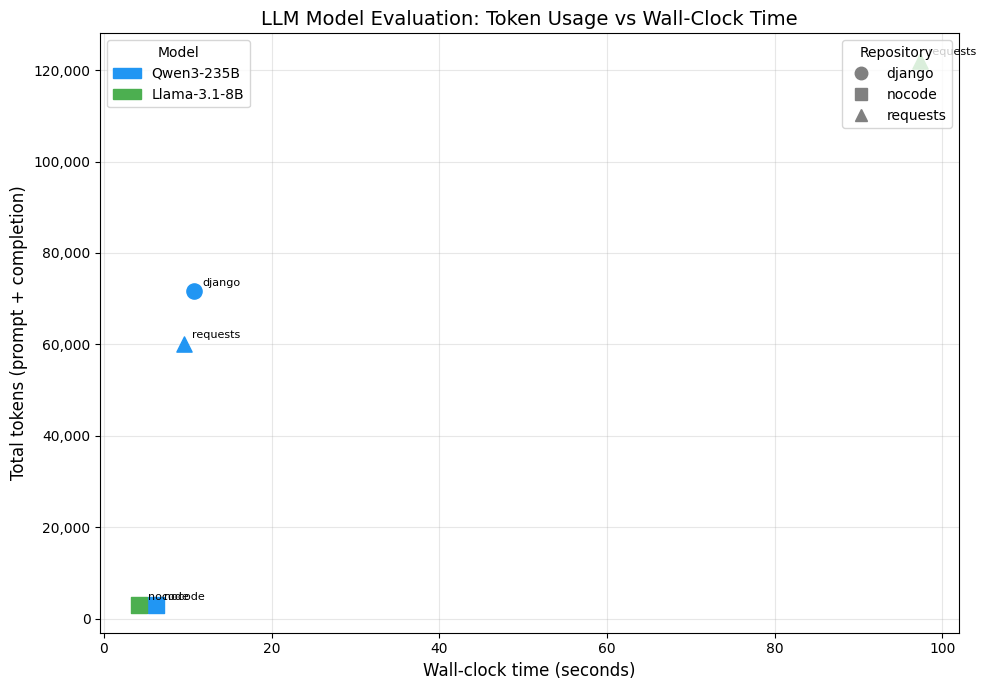

In [18]:
successful = [r for r in results if r.success]

MODEL_COLORS = {
    "Qwen3-235B":   "#2196F3",
    "Llama-3.1-8B": "#4CAF50",
    "GPT-4o":       "#FF5722",
}
MARKER_SHAPES = ["o", "s", "^"]
all_repos = sorted({r.repo for r in successful})
repo_markers = {repo: MARKER_SHAPES[i % 3] for i, repo in enumerate(all_repos)}

_, ax = plt.subplots(figsize=(10, 7))

for r in successful:
    ax.scatter(
        r.total_time, r.total_tokens,
        color=MODEL_COLORS.get(r.model_name, "#9E9E9E"),
        marker=repo_markers.get(r.repo, "o"),
        s=120, zorder=3,
    )
    ax.annotate(
        r.repo.split("/")[-1],
        xy=(r.total_time, r.total_tokens),
        xytext=(6, 4), textcoords="offset points", fontsize=8,
    )

ax.set_xlabel("Wall-clock time (seconds)", fontsize=12)
ax.set_ylabel("Total tokens (prompt + completion)", fontsize=12)
ax.set_title("LLM Model Evaluation: Token Usage vs Wall-Clock Time", fontsize=14)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.grid(True, alpha=0.3)

color_handles = [
    mpatches.Patch(color=c, label=n)
    for n, c in MODEL_COLORS.items()
    if any(r.model_name == n for r in successful)
]
shape_handles = [
    mlines.Line2D(
        [], [], color="gray", marker=repo_markers[repo],
        linestyle="None", markersize=9, label=repo.split("/")[-1],
    )
    for repo in all_repos
]
leg1 = ax.legend(handles=color_handles, title="Model", loc="upper left")
ax.add_artist(leg1)
ax.legend(handles=shape_handles, title="Repository", loc="upper right")

plt.tight_layout()
plt.savefig("evaluations/eval_results.png", dpi=150)
plt.show()